# Глубокая Q-сеть, вариант многослойного перцептрона (<span style="color: green"> 10 баллов за основную часть + 4 балла за бонусную часть </span>)

#### Дедлайн (жёсткий) задания: 24 апреля, 23:59 UTC+3

#### При сдаче задания нужно данный файл, использованные файлы *.py, а также папки с логами и видео поместить в архив, сохраняя относительные пути, и послать архив в систему сдачи.

### <span style="color: red"> Если работа была списана и/или сделана LLM, то за работу ставится 0 баллов </span>. 


В данной домашней работе требуется обучить агента CartPole, используя несколько вариантов DQN &mdash; приближённого алгоритм Q-обучения c различными вариациями механизма _experience_ _replay_ и целевой сетью (_target network_) &mdash; и пронаблюдать, лучше ли подход DQN работает по сравнению с рассмотренными ранее в каком-либо аспекте.

# Работа выполнена: Вицын Семён Сергеевич, Б05-131.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import os
import random
from IPython.display import clear_output
from queue import deque
from IPython.display import HTML
from pathlib import Path

import gymnasium as gym
from gymnasium.wrappers import RecordVideo

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR

import utils

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Создаем агента CartPole

In [5]:
def make_env():
    return gym.make(ENV_NAME, render_mode="rgb_array").unwrapped

In [6]:
ENV_NAME = 'CartPole-v1'

env = make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

In [7]:
print("размерность вектора состояний dim =", state_shape[0])
print("n_actions =", n_actions)

размерность вектора состояний dim = 4
n_actions = 2


# Приближённое Q-обучение: построение сети

Напишем несколько вариаций нейронной сети, способной переводить наблюдения в Q-ценности состояния. Так как агент устроен достаточно просто, не требуется сложная нейронная сеть. Будет достаточно MLP с небольшим количеством промежуточных слоев. Подробное описание можно найти в главах $4.1$ и $4.2$ пособия (https://arxiv.org/pdf/2201.09746.pdf)

**Вариации DQN**

<span style="color: green"> __(0.4 балла)__ </span>

In [8]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        # Задайте структуру нейронной сети здесь.
        # Убедитесь в том, что здесь определёны все параметры агента.
        assert len(state_shape) == 1
        state_dim = state_shape[0]
        self.model = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, self.n_actions)
        )

    def forward(self, state_t):
        """
        принимает наблюдение агента (тензор), возвращает qvalues (тензор)
        :параметр state_t: батч состояний, размерность = [batch_size, *state_dim=4]
        """
        # Используёте Вашу нейросеть для вычисления qvalues данного состояния state_t
        qvalues = self.model(state_t)

        assert len(qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        Как forward, только работает на numpy arrays, не на тензорах
        """
        model_device = next(self.parameters()).device
        states_t = torch.FloatTensor(states).to(model_device)
        qvalues = self.model(states_t)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """
        Выбрать действия для данных qvalues. Использует эпсилон-жадную стратегию исследования среды.
        """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

<span style="color: green"> __(0.8 балла)__ </span>

In [174]:
class TwinDQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        assert len(state_shape) == 1
        state_dim = state_shape[0]

        def build_net():
            return nn.Sequential(
                nn.Linear(state_dim, 32),
                nn.ReLU(),
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, 16),
                nn.ReLU(),
                nn.Linear(16, self.n_actions)
            )

        # Две независимые сети Q
        self.q_net1 = build_net()
        self.q_net2 = build_net()

    def forward(self, state_t):
        """
        Возвращает qvalues обеих сетей
        """
        q1 = self.q_net1(state_t)
        q2 = self.q_net2(state_t)

        assert q1.shape == q2.shape
        return q1, q2

    def get_qvalues(self, states):
        model_device = next(self.parameters()).device
        states_t = torch.FloatTensor(states).to(model_device)
        q1 = self.q_net1(states_t)
        q2 = self.q_net2(states_t)
        return q1.data.cpu().numpy(), q2.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """
        Использует qvalues от одной из сетей для выбора действия
        """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

<span style="color: green"> __(1 балл)__ </span>

In [175]:
class DuelingDQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        assert len(state_shape) == 1
        state_dim = state_shape[0]

        # Общая часть сети (shared backbone)
        self.shared_network = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
        )

        # Голова для значения (V(s))
        self.value_head = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Голова для преимущества (A(s,a))
        self.advantage_head = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, self.n_actions)
        )

    def forward(self, state_t):
        batch_size = state_t.shape[0]
        features = self.shared_network(state_t)

        # Комбинируем V(s) и A(s,a) для получения Q(s,a)
        values = self.value_head(features)
        advantages = self.advantage_head(features)
        qvalues = values + (advantages - advantages.mean(dim=-1, keepdims=True))

        assert qvalues.shape == (batch_size, self.n_actions)

        return qvalues

    def get_qvalues(self, states):
        model_device = next(self.parameters()).device
        states_t = torch.FloatTensor(states).to(model_device)
        qvalues = self.forward(states_t)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

**Подсчет средней награды**

In [9]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """
    Играет qvalues полных эпизодов. Если greedy=True, то действия берутся из детерминированной
    стратегии как argmax(qvalues). Возвращает среднюю награду.
    """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    env.close()
    return np.mean(rewards)

In [177]:
def evaluate_twin(env, agent, n_games=1, greedy=False, t_max=10000):
    """
    Играет полные эпизоды. Если greedy=True, то действия берутся из argmax(qvalues).
    Возвращает среднюю награду.
    """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            q_1, q_2 = agent.get_qvalues([s])  # Возвращает qvalues из forward()
            action = q_1.argmax(axis=-1)[0] if greedy else agent.sample_actions(q_1)[0]
            s, r, done, _, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    env.close()
    return np.mean(rewards)

Проверим, что *evaluate* и *evaluate_twin* работают

In [11]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)
evaluate(env, agent, n_games=1)

13.0

In [179]:
agent_dueling = DuelingDQNAgent(state_shape, n_actions, epsilon=0.5).to(device)
evaluate(env, agent_dueling, n_games=1)

9.0

In [180]:
agent_twin = TwinDQNAgent(state_shape, n_actions, epsilon=0.5).to(device)
evaluate_twin(env, agent_twin, n_games=1)

14.0

# Experience Replay
Сущетвует мощный метод, который можно использовать для улучшения сходимости _off-policy_ алгоритмов относительно общего количества используемых сэмплов: _Experience_ _Replay_. Смысл состоит в том, что появляется возможность настроить агента с помощью Q-обучения и EV-SARSA на кортежах `<s,a,r,s'>`, даже если они не сэмплированы из текущей политики агента. Итак, здесь требуется реализовать следующее:

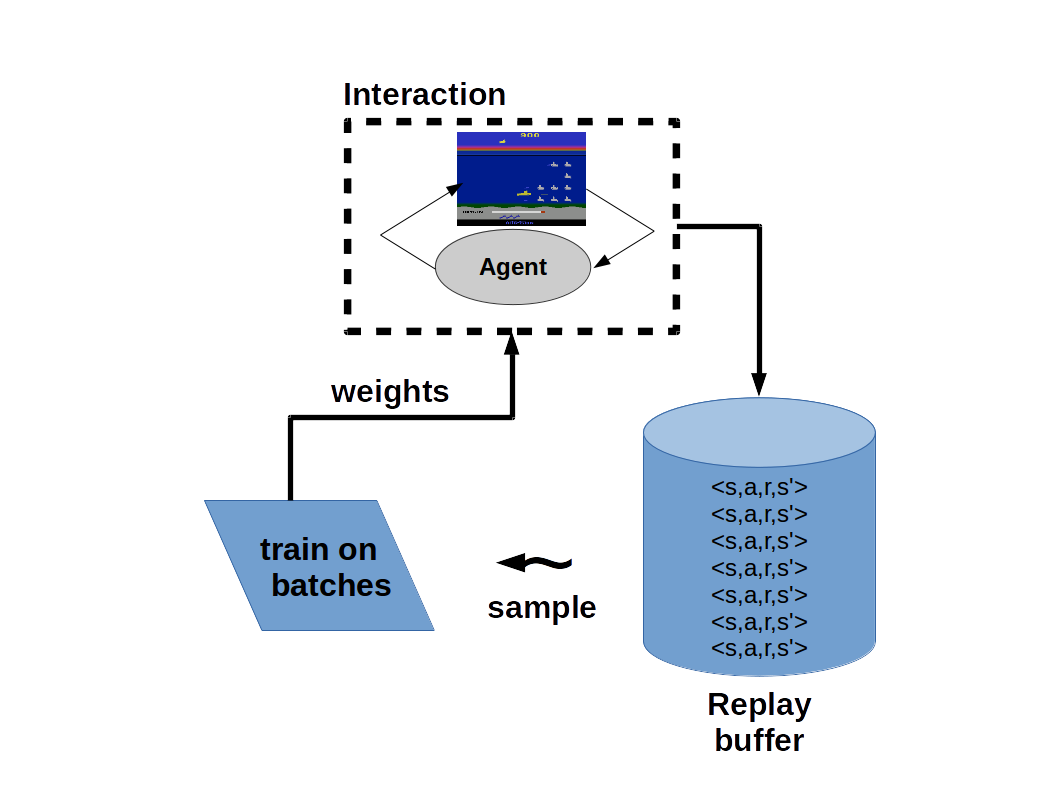

#### Обучение с experience replay
1. Сыграть шаг игры, отсэмплировать `<s,a,r,s'>`.
2. Обновить q-values на основе `<s,a,r,s'>`.
3. Записать `<s,a,r,s'>` в буфер.
 3. Если буфер полный, то удалить ранние данные.
4. Сэмплировать K таких переходов из данного буфера и обновить q-values на их основе.

#### Интерфейс довольно простой:
* `exp_replay.add(obs, act, rw, next_obs, done)`  &mdash; сохраняет кортеж (s,a,r,s',done) в буфер
* `exp_replay.sample(batch_size)` &mdash; возвращает наблюдения, действия, награды, следующие наблюдения и is_done для `batch_size` случайных сэмплов.
* `len(exp_replay)` &mdash; возвращает количество элементов, хранящихся в буфере на данный момент.


Для применения такого обучения требуется, во-первых, реализация структуры памяти, которая будет работать как буфер.

<span style="color: green"> __(0.6 балла)__ </span>

In [89]:
class ReplayBuffer(object):
    def __init__(self, size, alpha=0.6):
        """
        Создаёт буфер реплеев.
        Параметры
        ----------
        size: int
            Максимальное количество хранящихся единовременно переходов. При переполнении буфера старые
            записи удаляются.

        Замечание: для данного задания можно выбрать любую структуру данных.
              Если Вам достаточно простого решения, то можно просто хранить список кортежей (s, a, r, s')
              в self._storage. Однако, можно найти более быстрые и/или эффективные по памяти способы
              реализации самого хранения переходов.
        """
        #self._storage = []
        self._storage = deque(maxlen=size)
        self._maxsize = size
        self._priorities = deque(maxlen=size)
        self._alpha = alpha

    def __len__(self):
        return len(self._storage)

    def add_random(self, obs_t, action, reward, obs_tp1, done):
        '''
        Убедитесь, что _storage не превзойдёт по размерам _maxsize.
        Убедитесь, что FIFO правило выполняется: старейшие прецеденты должны удаляться раньше всех.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        self._storage.append(data)

    def sample_random(self, batch_size):
        """Сэмплирование батча переходов.
        Параметры
        ----------
        batch_size: int
            Сколько переходов сэмплировать.
        Возвращает
        -------
        obs_batch: np.array
            батч наблюдений (состояний)
        act_batch: np.array
            батч действий, выполненных на основе obs_batch
        rew_batch: np.array
            награды, полученные в качестве результата выполнения act_batch
        next_obs_batch: np.array
            следующие наблюдения (состояния), полученные после выполнения act_batch
        done_mask: np.array
            done_mask[i] = 1, если выполнение act_batch[i] повлекло
            окончание эпизода и 0 иначе.
        """
        #storage = self._storage

        #< случайно сгенерировать batch_size индексов сэмплов в буфере >
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]

        # собрать <s,a,r,s',done> для каждого индекса
        states, actions, rewards, next_states, is_dones = [], [], [], [], []
        for idx in idxes:
            state, action, reward, next_state, is_done = self._storage[idx]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            is_dones.append(is_done)

        # < states > , < actions >, < rewards >,  < next_states >, < is_done >
        return (np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(is_dones))

In [133]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add_random(env.reset()[0], env.action_space.sample(), 1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(5)

assert len(exp_replay) == 10, "размер буфера должен быть равен 10, потому что это максимальная вместимость"

<span style="color: green"> __(0.6 балла)__ </span>

In [91]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Сыграть в игру n_steps шагов, записать каждый (s,a,r,s', done) в exp_replay буфер.
    Как только игра заканчивается, добавляется запись с done=True и среда env перезапускается.
    Гарантируетcя, что env находится в состоянии done=False после работы функции.

    ПРОСЬБА НЕ ПЕРЕЗАПУСКАТЬ ENV, ПОКА ОНА НЕ В СОСТОЯНИИ "DONE"

    :возвращает: сумму наград по времени и состояние, в котором среда оказалась
    """
    s = initial_state
    sum_rewards = 0

    # Сыграть в игру n_steps шагов согласно инструкциям выше
    for _ in range(n_steps):
        action = agent.sample_actions(agent.get_qvalues([s]))[0]
        new_s, r, done, _, _ = env.step(action)
        exp_replay.add_random(s, action, r, new_s, done)
        sum_rewards += r
        if done:
            s, _ = env.reset()
        else:
            s = new_s

    return sum_rewards, s

Для TwinDQN функция *play_and_record* будет иметь немного другой вид. Записывайте результат любой из двух моделей

<span style="color: green"> __(0.6 балла)__ </span>

In [105]:
def play_and_record_twin(initial_state, agent, env, exp_replay, n_steps=1, regime='random'):
    """
    Сыграть в игру n_steps шагов, записать каждый (s,a,r,s', done) в exp_replay буфер.
    Как только игра заканчивается, добавляется запись с done=True и среда env перезапускается.
    Гарантируетcя, что env находится в состоянии done=False после работы функции.

    ПРОСЬБА НЕ ПЕРЕЗАПУСКАТЬ ENV, ПОКА ОНА НЕ В СОСТОЯНИИ "DONE"

    :возвращает: сумму наград по времени и состояние, в котором среда оказалась
    """
    s = initial_state
    sum_rewards = 0

    # Сыграть в игру n_steps шагов согласно инструкциям выше
    for _ in range(n_steps):
        q1, q2 = agent.get_qvalues([s])
        action = agent.sample_actions(q1)[0]
        new_s, r, done, _, _ = env.step(action)
        exp_replay.add_random(s, action, r, new_s, done)
        sum_rewards += r
        if done:
            s, _ = env.reset()
        else:
            s = new_s
            
    return sum_rewards, s

In [134]:
# Протестируйте Ваш код.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# если вы используете собственный experience replay буфер, то некоторые из тестов, возможно, потребуется
# скорректировать.
# Убедитесь в том, что Вы знаете, что Ваш код делает
assert len(exp_replay) == 1000,\
    "play_and_record должна добавить ровно 1000 шагов, но вместо этого добавила %i" % len(exp_replay)

is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1,\
"Убедитесь, что Вы перезапускаете игру, как только она 'done', и корректно записываете is_done в буфер."\
"Получена %f доля is_done за %i шагов. [Если думаете, что Вам не повезло, то просто перезапустите тест.]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,),\
        "батч действий должен иметь размер (10,), но имееет %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,),\
        "батч наград должен иметь размер (10,), но имееет %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,),\
        "батч is_done должен иметь размер (10,), но имееет %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones],\
        "is_done должен быть строго True или False"
    assert [0 <= a < n_actions for a in act_batch],\
        "действия должны быть в промежутке [0, n_actions]"

print("Отлично справились!")

Отлично справились!


# Целевые сети

Также будет реализована так называемая "целевая сеть" &mdash; копия весов нейронной сети агента, используемая для оценки целевого значения Q-функции:

Сама по себе сеть представляет собой точную копию сети агента, но её параметры не обучаются. Наоборот, они берутся из обучаемой сети агента раз в несколько итераций цикла обучения.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

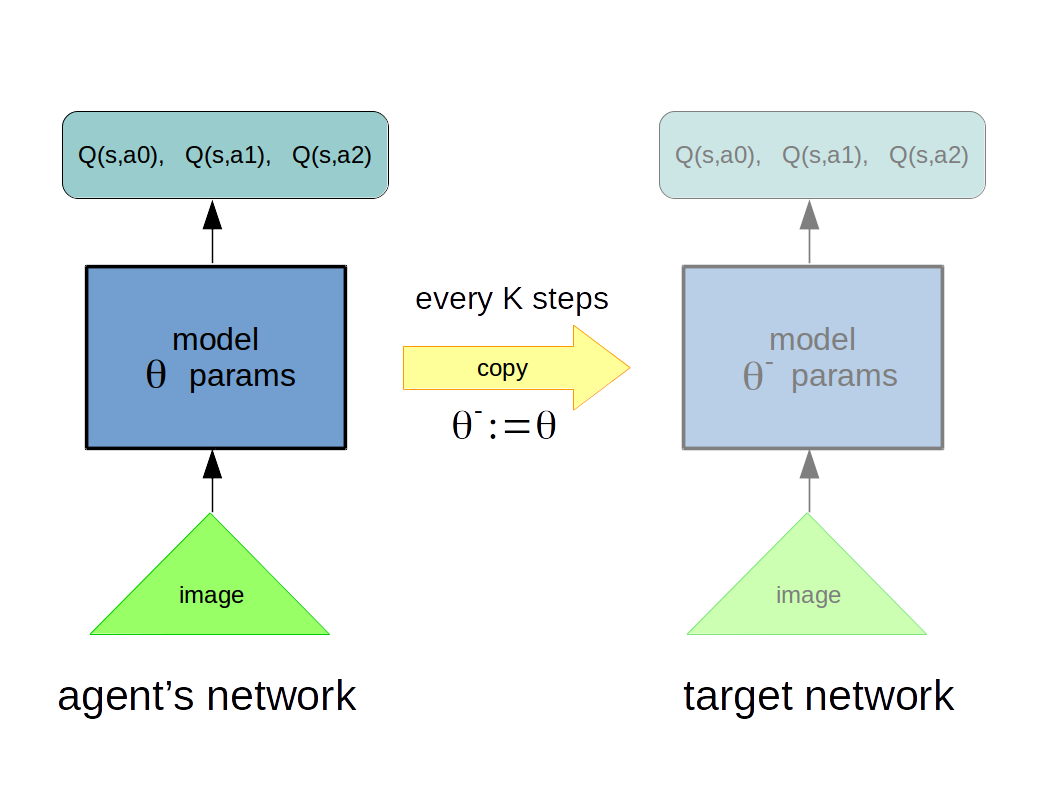

Реализуем функции потерь для модификаций DQN

<span style="color: green"> __(1 балл)__ </span>

In [135]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """
    Вычислите td функцию потерь, используя только операции PyTorch. Используйте формулы выше.
    """
    states = torch.tensor(states, device=device, dtype=torch.float)           # размер: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.long)          # размер: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)         # размер: [batch_size]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float) # размер: [batch_size, *state_shape]
    is_done = torch.tensor(is_done.astype('float32'), device=device, dtype=torch.float)  # размер: [batch_size]
    is_not_done = 1 - is_done

    # получить q-values для всех действий в текущих состояниях
    predicted_qvalues = agent(states)

    # вычислить q-values для всех действий в следующих состояниях
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)

    # выбрать q-values для соотоветствующих выбранных действий
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]

    # вычислить V*(next_states), используя предсказанные следующие q-values
    next_state_values, _ = torch.max(predicted_next_qvalues, dim=-1)

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0],\
        "нужно предсказывать одно действие для состояния"

    # вычислить "target q-values" для функции потерь - то, что внутри квадратных скобок в формуле выше.
    # в последнем состоянии использовать упрощённую формулу: Q(s,a) = r(s,a) так как s' не существует
    # Вы можете умножить следующие состояния на is_not_done для достижения этого.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    assert predicted_qvalues_for_actions.shape == target_qvalues_for_actions.shape

    # среднеквадратическая функция потерь для минимизации
    loss = torch.nn.functional.mse_loss(predicted_qvalues_for_actions, target_qvalues_for_actions)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2,\
            "убедитесь, что Вы предсказали все q-values для всех действий в следующих состояниях"
        assert next_state_values.data.dim() == 1,\
            "убедитесь, что Вы вычислили V(s') как максимум по оси действий в тензоре, а не по всем осям"
        assert target_qvalues_for_actions.data.dim() == 1,\
            "что-то не то с целевыми q-values, они должны быть вектором"

    return loss

<span style="color: green"> __(1 балл)__ </span>

In [149]:
def compute_td_loss_twin(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(is_done.astype('float32'), device=device, dtype=torch.float)
    is_not_done = 1 - is_done

    # ------- Q(s, a) -------
    q1, q2 = agent(states)
    pred_qvalues_1 = q1[range(len(actions)), actions]
    pred_qvalues_2 = q2[range(len(actions)), actions]

    # ------- Q(s', a') -------
    with torch.no_grad():
        q1_next, q2_next = target_network(next_states)

        next_actions_q1 = q1_next.argmax(axis=-1, keepdims=True)
        next_actions_q2 = q2_next.argmax(axis=-1, keepdims=True)

        q12 = q1_next.gather(1, next_actions_q2).squeeze(1)
        q22 = q2_next.gather(1, next_actions_q2).squeeze(1)

        q11 = q1_next.gather(1, next_actions_q1).squeeze(1)
        q21 = q2_next.gather(1, next_actions_q1).squeeze(1)

        q1_next_min = torch.min(q12, q22)
        q2_next_min = torch.min(q11, q21)

    # ------- Targets -------
    target_qvalues_1 = rewards + gamma * q1_next_min * is_not_done
    target_qvalues_2 = rewards + gamma * q2_next_min * is_not_done

    # Сумма среднеквадратичных квадратичных потерь для двух сетей
    loss = (torch.nn.functional.mse_loss(pred_qvalues_1, target_qvalues_1) 
            + torch.nn.functional.mse_loss(pred_qvalues_2, target_qvalues_2))
    
    return loss


In [136]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (),\
    "Вы должны вернуть скаляр значения функции потерь - среднее по батчу."
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0),\
    "Функция потерь должна быть дифференцируема относительно весов сети."
assert np.all(next(target_network.parameters()).grad is None),\
    "Целевая сеть не должна быть дифференцируемой."

In [142]:
target_network = DuelingDQNAgent(agent_dueling.state_shape, agent_dueling.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent_dueling.state_dict())

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent_dueling, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (),\
    "Вы должны вернуть скаляр значения функции потерь - среднее по батчу."
assert np.any(next(agent_dueling.parameters()).grad.data.cpu().numpy() != 0),\
    "Функция потерь должна быть дифференцируема относительно весов сети."
assert np.all(next(target_network.parameters()).grad is None),\
    "Целевая сеть не должна быть дифференцируемой."

In [150]:
target_network = TwinDQNAgent(agent_twin.state_shape, agent_twin.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent_twin.state_dict())

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample_random(10)

loss = compute_td_loss_twin(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent_twin, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (),\
    "Вы должны вернуть скаляр значения функции потерь - среднее по батчу."
assert np.any(next(agent_twin.parameters()).grad.data.cpu().numpy() != 0),\
    "Функция потерь должна быть дифференцируема относительно весов сети."
assert np.all(next(target_network.parameters()).grad is None),\
    "Целевая сеть не должна быть дифференцируемой."

# Обучение

In [187]:
seed = 617
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [14]:
env = make_env()
state_dim = env.observation_space.shape
n_actions = env.action_space.n

**DQN**

In [189]:
state, _ = env.reset()
agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

In [190]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Меньше, чем 100 Mb RAM, доступно.
            Убедитесь, что размер буфера не слишком большой.
            Также проверьте, может, другие процессы потребляют сильно много RAM.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [191]:
timesteps_per_epoch = 100
batch_size = 64
total_steps = 10**4
decay_steps = 5 * 10**3

opt = torch.optim.Adam(agent.parameters(), lr=1e-3)
opt.zero_grad()

init_epsilon = 0.5
final_epsilon = 0.05

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 10
gamma = 0.99

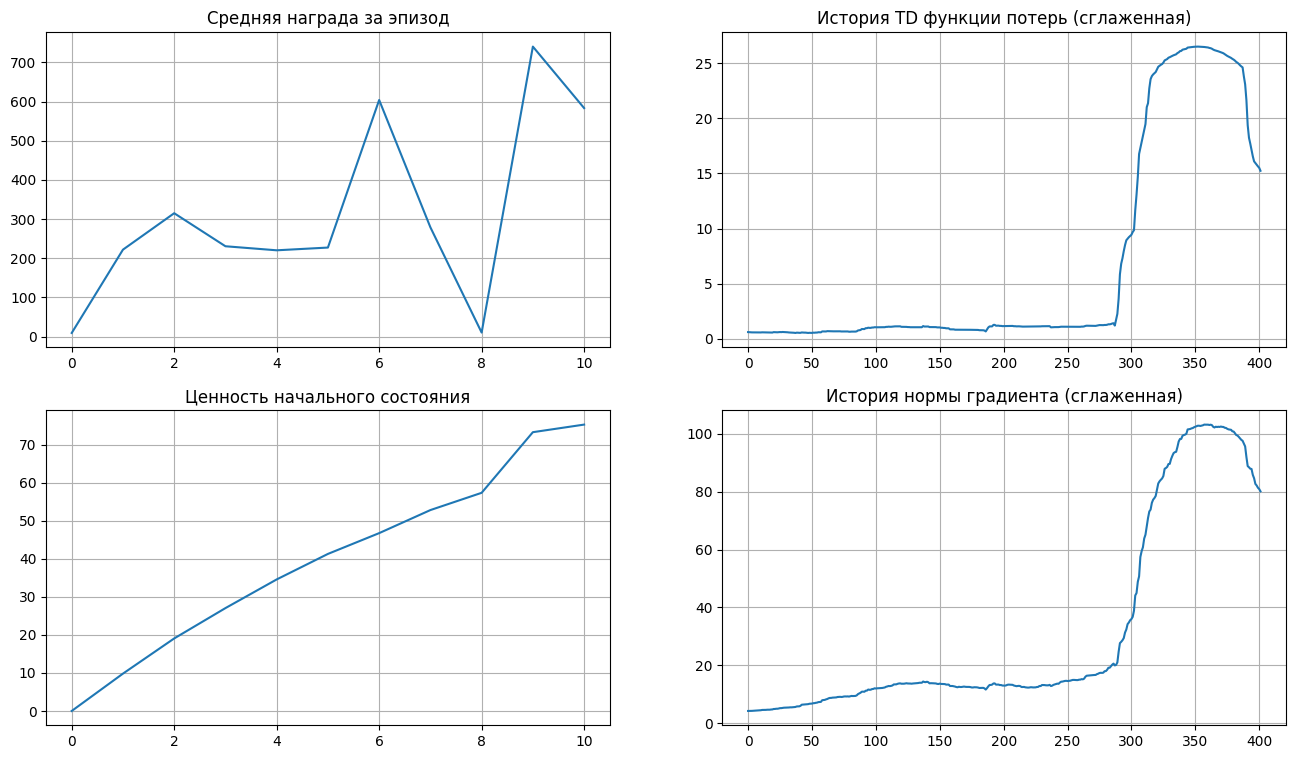

100%|██████████| 10001/10001 [06:56<00:00, 24.00it/s]


In [192]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('Меньше, чем 100 Mb RAM, доступно, заморозка процедуры обучения')
        print('убедитесь, что всё в порядке и пошлите сигнал KeyboardInterrupt для продолжения')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # игра
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # обучение
    obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = exp_replay.sample_random(batch_size)

    loss = compute_td_loss(obs_batch, act_batch, rew_batch, next_obs_batch, done_mask, agent, target_network, gamma)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm).item()
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Загрузка весов агента в target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # Оценка агента
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3, greedy=True, t_max=1000))
        initial_state_q_values = agent.get_qvalues([make_env().reset()[0]])
        initial_state_v_history.append(np.max(initial_state_q_values))

        print("размер буфера = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Средняя награда за эпизод")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("История TD функции потерь (сглаженная)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Ценность начального состояния")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("История нормы градиента (сглаженная)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        clear_output(True)
        plt.show()

In [193]:
final_score = evaluate(make_env(), agent, n_games=30, greedy=True, t_max=1000)
print('финальный счёт:', final_score)
assert final_score > 500, 'недостаточно хорошо для DQN'
print('Отлично справились')

финальный счёт: 614.4
Отлично справились


Теперь, когда сеть обучилась, запишем видео

In [194]:
# запись эпизодов
with RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"),
    video_folder="./videos_DQN/False",
    episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [evaluate(env_monitor, agent, greedy=False, t_max=1000) for _ in range(5)]

Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-0.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/False/rl-video-episode-4.mp4


In [195]:
video_paths = sorted([s for s in Path('videos_DQN', 'False').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

In [196]:
# запись эпизодов
with RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"),
    video_folder="./videos_DQN/True",
    episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [evaluate(env_monitor, agent, greedy=True, t_max=1000) for _ in range(5)]

Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-0.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_DQN/True/rl-video-episode-4.mp4


In [197]:
video_paths = sorted([s for s in Path('videos_DQN', 'True').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

**TwinDQN**

In [203]:
state, _ = env.reset()

agent = TwinDQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = TwinDQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [204]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Меньше, чем 100 Mb RAM, доступно.
            Убедитесь, что размер буфера не слишком большой.
            Также проверьте, может, другие процессы потребляют сильно много RAM.
            """
             )
        break
    play_and_record_twin(state, agent, env, exp_replay, n_steps=10**2, regime='random')
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [205]:
timesteps_per_epoch = 100
batch_size = 64
total_steps = 1 * 10**4
decay_steps = 5 * 10**3

opt = torch.optim.Adam(agent.parameters(), lr=1e-3)
opt.zero_grad()
init_epsilon = 0.5
final_epsilon = 0.05

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 10
gamma = 0.99

In [206]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

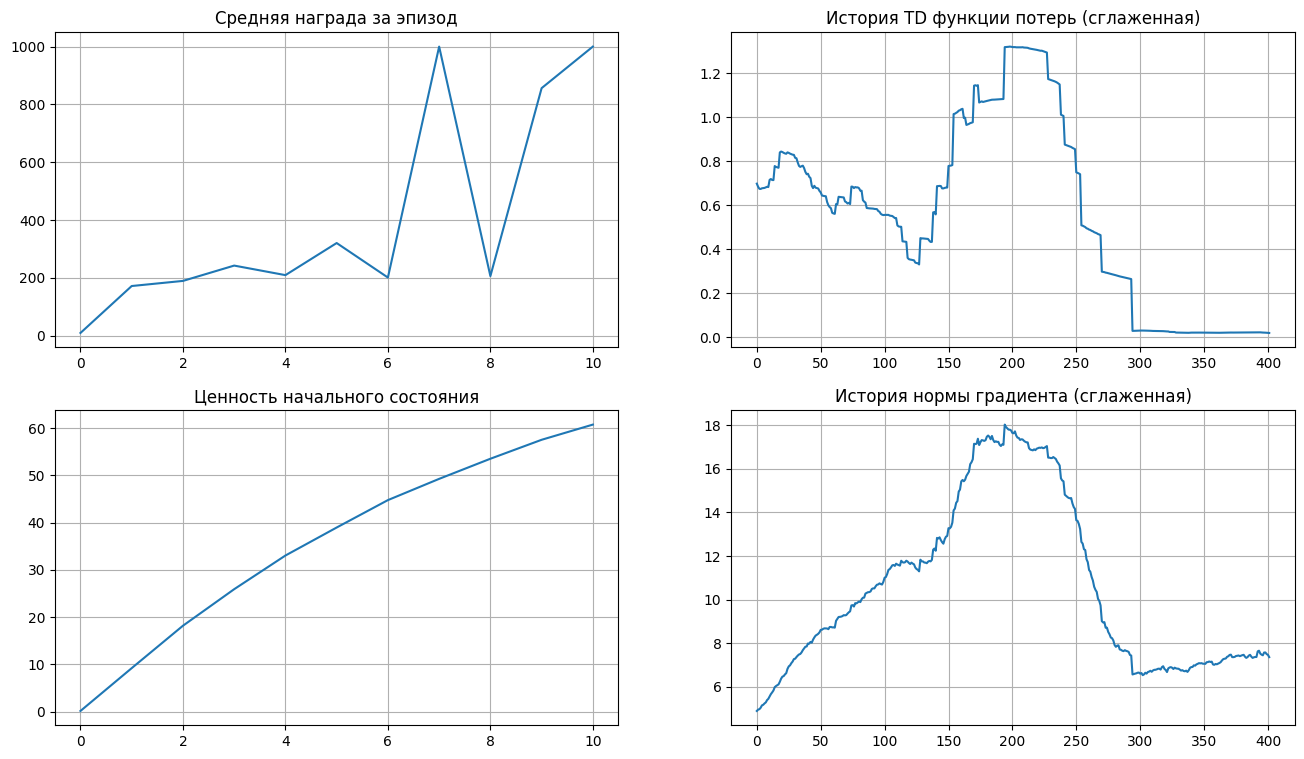

100%|██████████| 10001/10001 [10:25<00:00, 16.00it/s]


In [207]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('Меньше, чем 100 Mb RAM, доступно, заморозка процедуры обучения')
        print('убедитесь, что всё в порядке и пошлите сигнал KeyboardInterrupt для продолжения')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # игра
    _, state = play_and_record_twin(state, agent, env, exp_replay, timesteps_per_epoch)

    # обучение
    obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = exp_replay.sample_random(batch_size)

    loss = compute_td_loss_twin(obs_batch, act_batch, rew_batch, next_obs_batch, done_mask, agent, target_network, gamma)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm).item()
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Загрузка весов агента в target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # Оценка агента
        mean_rw_history.append(evaluate_twin(make_env(), agent, n_games=3, greedy=True, t_max=1000))
        initial_state_q_values = agent.get_qvalues([make_env().reset()[0]])
        initial_state_v_history.append(np.max(initial_state_q_values))

        print("размер буфера = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Средняя награда за эпизод")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("История TD функции потерь (сглаженная)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Ценность начального состояния")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("История нормы градиента (сглаженная)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        clear_output(True)
        plt.show()

In [209]:
final_score = evaluate_twin(make_env(), agent, n_games=30, greedy=True, t_max=1000)
print('финальный счёт:', final_score)
assert final_score > 500, 'недостаточно хорошо для twin DQN'
print('Отлично справились')

финальный счёт: 1000.0
Отлично справились


In [210]:
# запись эпизодов
with RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"),
    video_folder="./videos_Twin/False",
    episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [evaluate_twin(env_monitor, agent, greedy=False, t_max=1000) for _ in range(5)]

Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-0.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/False/rl-video-episode-4.mp4


In [211]:
video_paths = sorted([s for s in Path('videos_Twin', 'False').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

In [212]:
# запись эпизодов
with RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"),
    video_folder="./videos_Twin/True",
    episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [evaluate_twin(env_monitor, agent, greedy=True, t_max=1000) for _ in range(5)]

Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-0.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Twin/True/rl-video-episode-4.mp4


In [213]:
video_paths = sorted([s for s in Path('videos_Twin', 'True').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

**DuelingDQN**

In [230]:
state, _ = env.reset()

agent = DuelingDQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DuelingDQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [231]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Меньше, чем 100 Mb RAM, доступно.
            Убедитесь, что размер буфера не слишком большой.
            Также проверьте, может, другие процессы потребляют сильно много RAM.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [232]:
timesteps_per_epoch = 100
batch_size = 64
total_steps = 2 * 10**4
decay_steps = 1 * 10**4

opt = torch.optim.Adam(agent.parameters(), lr=1e-3)
opt.zero_grad()

init_epsilon = 0.75
final_epsilon = 0.05

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 10
gamma = 0.99

In [233]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

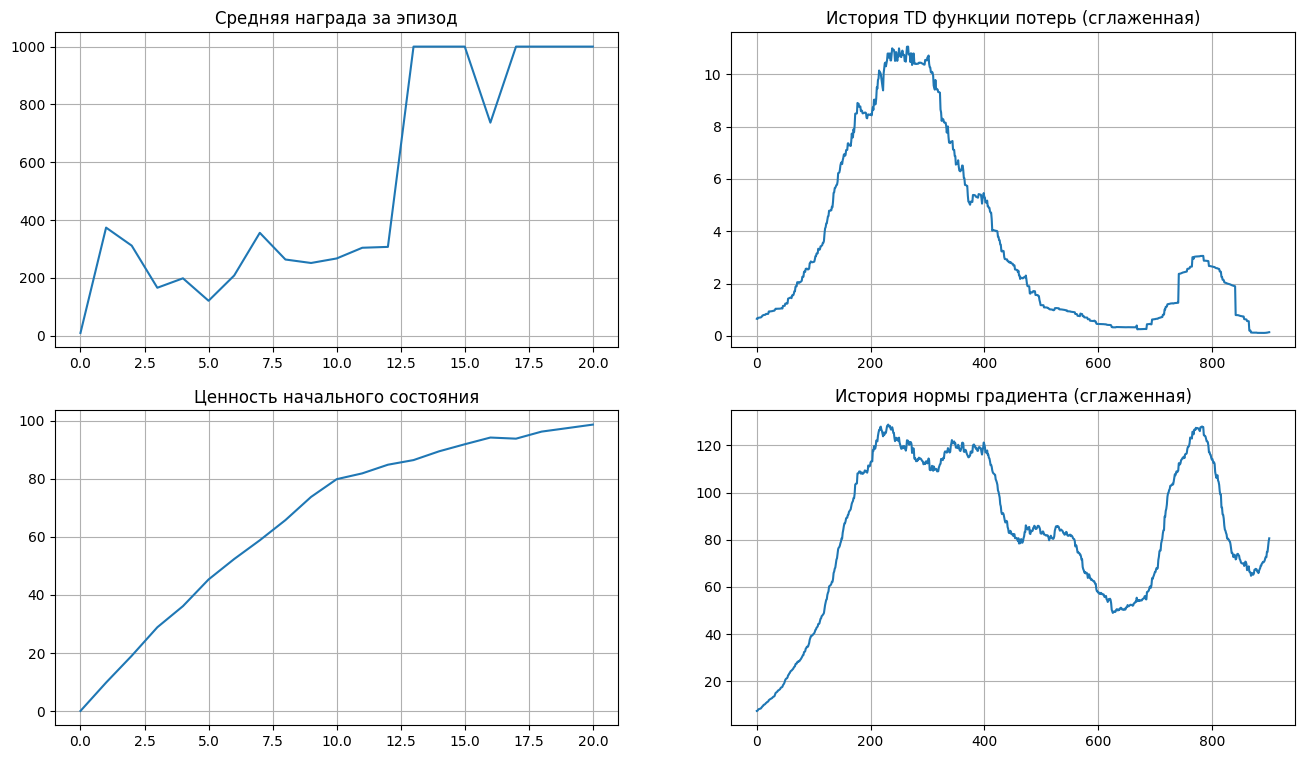

100%|██████████| 20001/20001 [21:37<00:00, 15.41it/s]


In [234]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('Меньше, чем 100 Mb RAM, доступно, заморозка процедуры обучения')
        print('убедитесь, что всё в порядке и пошлите сигнал KeyboardInterrupt для продолжения')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # игра
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # обучение
    obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = exp_replay.sample_random(batch_size)

    loss = compute_td_loss(obs_batch, act_batch, rew_batch, next_obs_batch, done_mask, agent, target_network, gamma)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm).item()
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Загрузка весов агента в target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # Оценка агента
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3, greedy=True, t_max=1000))
        initial_state_q_values = agent.get_qvalues([make_env().reset()[0]])
        initial_state_v_history.append(np.max(initial_state_q_values))

        print("размер буфера = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Средняя награда за эпизод")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("История TD функции потерь (сглаженная)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Ценность начального состояния")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("История нормы градиента (сглаженная)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        clear_output(True)
        plt.show()

In [235]:
final_score = evaluate(make_env(), agent, n_games=30, greedy=True, t_max=1000)
print('финальный счёт:', final_score)
assert final_score > 500, 'недостаточно хорошо для DQN'
print('Отлично справились')

финальный счёт: 1000.0
Отлично справились


In [237]:
# запись эпизодов
with RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"),
    video_folder="./videos_Dueling/False",
    episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [evaluate(env_monitor, agent, greedy=False, t_max=1000) for _ in range(5)]

Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-0.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/False/rl-video-episode-4.mp4


In [238]:
video_paths = sorted([s for s in Path('videos_Dueling', 'False').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

In [239]:
# запись эпизодов
with RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"),
    video_folder="./videos_Dueling/True",
    episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [evaluate(env_monitor, agent, greedy=True, t_max=1000) for _ in range(5)]

Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-0.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Dueling/True/rl-video-episode-4.mp4


In [240]:
video_paths = sorted([s for s in Path('videos_Dueling', 'True').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# DQN with multiple steps

Выше мы использовали одношаговую стратегию семплирования в DQN. Такой подход страдает из-за проблемы отложенного сигнала  и сопряжённой с ней в контексте нейросетевой аппроксимации проблемы накапливающейся ошибки. Эвристика для борьбы с этой проблемой - распространять награду за одну итерацию на несколько шагов вперед. Грубо говоря, в буфере переходов будем хранить
\begin{equation*}
  T=\left(s,a,\sum_{n=0}^{N-1}\gamma^nr^{(n)},s^{(N)},done\right).
\end{equation*}

Для этого нам придется переписать *ReplayBuffer* и *play_and_record*. Использовать будем обычный DQNAgent.

<span style="color: green"> __(2 балла)__ </span>

In [41]:
class ReplayBuffer_multistep(object):
    def __init__(self, size, gamma=0.99, n_steps=5):
        self._storage = deque(maxlen=size)
        self._maxsize = size
        self._gamma = gamma
        self._n_steps = n_steps
        self._n_step_buffer = deque(maxlen=n_steps)

    def __len__(self):
        return len(self._storage)

    def add_multi_step(self, obs_t, action, reward, obs_tp1, done):
        """
        Добавляет новый переход и, если накоплено достаточно шагов, сохраняет N-step переход.
        """
        self._n_step_buffer.append((obs_t, action, reward, obs_tp1, done))
        
        if not done and len(self._n_step_buffer) < self._n_steps:
            return
        

        if not done:
            final_done=False
            final_idx = self._n_steps - 1
            s_tpN = self._n_step_buffer[final_idx][3]
        else:
            final_done=True
            final_idx = len(self._n_step_buffer) - 1
            s_tpN = self._n_step_buffer[final_idx][3]

        s_t = self._n_step_buffer[0][0]
        a_t = self._n_step_buffer[0][1]

        R = 0.0
        for idx in range(final_idx + 1):
            s, a, r, s_next, d = self._n_step_buffer[idx]
            R += (self._gamma ** idx) * r


        self._storage.append((s_t, a_t, R, s_tpN, final_done))

    def sample_random(self, batch_size):
        idxes = np.random.choice(len(self._storage), batch_size)
        sample = list(zip(*(self._storage[i] for i in idxes)))
        return (np.array(sample[0]), np.array(sample[1]), np.array(sample[2]),
                np.array(sample[3]), np.array(sample[4]))

In [18]:
def play_and_record_multistep(initial_state, agent, env, exp_replay, n_steps=1, regime='random'):
    s = initial_state
    sum_rewards = 0

    for _ in range(n_steps):
        q = agent.get_qvalues([s])
        a = agent.sample_actions(q)[0]
        new_s, r, done, _, _ = env.step(a)

        exp_replay.add_multi_step(s, a, r, new_s, done)
        sum_rewards += r

        if done:
            s, _ = env.reset()
            exp_replay._n_step_buffer.clear()  # очищаем, иначе накопятся неправильные переходы
        else:
            s = new_s

    return sum_rewards, s

<span style="color: green"> __(1 балл)__ </span>

In [19]:
def compute_td_loss_multistep(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99, n_steps=3,
                    check_shapes=False,
                    device=device):
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(is_done.astype('float32'), device=device, dtype=torch.float)
    is_not_done = 1 - is_done

    predicted_qvalues = agent(states)

    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)

    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]

    next_state_values, _ = torch.max(predicted_next_qvalues, dim=-1)

    # теперь учитываем n шагов при дисконте
    target_qvalues_for_actions = rewards + (gamma ** n_steps) * next_state_values * is_not_done

    # Среднеквадратичные потери
    loss = torch.nn.functional.mse_loss(predicted_qvalues_for_actions, target_qvalues_for_actions)
    
    return loss

In [30]:
state, _ = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [31]:
exp_replay = ReplayBuffer_multistep(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Меньше, чем 100 Mb RAM, доступно.
            Убедитесь, что размер буфера не слишком большой.
            Также проверьте, может, другие процессы потребляют сильно много RAM.
            """
             )
        break
    play_and_record_multistep(state, agent, env, exp_replay, n_steps=10**2, regime='random')
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

8119


In [32]:
timesteps_per_epoch = 100
batch_size = 64
total_steps = 1 * 10**4
decay_steps = 5 * 10**3

opt = torch.optim.Adam(agent.parameters(), lr=1e-3)
opt.zero_grad()

init_epsilon = 0.5
final_epsilon = 0.05

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 10
gamma = 0.99

In [33]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

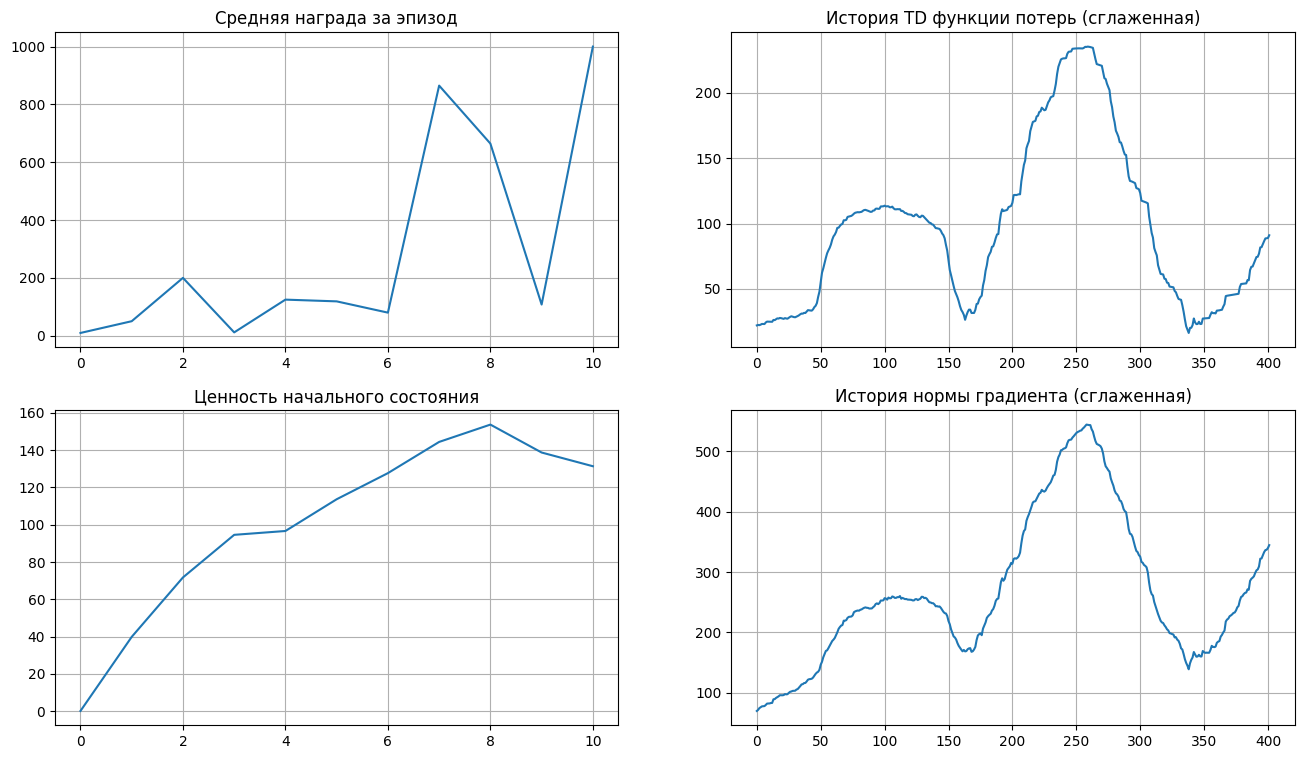

100%|██████████| 10001/10001 [06:54<00:00, 24.12it/s]


In [34]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('Меньше, чем 100 Mb RAM, доступно, заморозка процедуры обучения')
        print('убедитесь, что всё в порядке и пошлите сигнал KeyboardInterrupt для продолжения')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # игра
    _, state = play_and_record_multistep(state, agent, env, exp_replay, timesteps_per_epoch)

    # обучение
    obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = exp_replay.sample_random(batch_size)

    loss = compute_td_loss_multistep(obs_batch, act_batch, rew_batch, next_obs_batch, done_mask, agent, target_network, gamma)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm).item()
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Загрузка весов агента в target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # Оценка агента
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3, greedy=True, t_max=1000))
        initial_state_q_values = agent.get_qvalues([make_env().reset()[0]])
        initial_state_v_history.append(np.max(initial_state_q_values))

        print("размер буфера = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Средняя награда за эпизод")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("История TD функции потерь (сглаженная)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Ценность начального состояния")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("История нормы градиента (сглаженная)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        clear_output(True)
        plt.show()

In [35]:
final_score = evaluate(make_env(), agent, n_games=30, greedy=True, t_max=1000)
print('финальный счёт:', final_score)
assert final_score > 500, 'недостаточно хорошо для DQN'
print('Отлично справились')

финальный счёт: 1000.0
Отлично справились


<span style="color: green"> __(1 балл)__ </span> Проварьируйте параметр $n\_steps$ и представьте результаты на едином графике. Какой параметр оказался лучше всего? Почему?

n_steps = 2

In [94]:
mean_rw_history_2 = []
td_loss_history_2 = []
grad_norm_history_2 = []
initial_state_v_history_2 = []

state, _ = env.reset()

agent_2 = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network_2 = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network_2.load_state_dict(agent_2.state_dict())

exp_replay = ReplayBuffer_multistep(10**4, n_steps=2)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Меньше, чем 100 Mb RAM, доступно.
            Убедитесь, что размер буфера не слишком большой.
            Также проверьте, может, другие процессы потребляют сильно много RAM.
            """
             )
        break
    play_and_record_multistep(state, agent_2, env, exp_replay, n_steps=10**2, regime='random')
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

9528


In [95]:
timesteps_per_epoch = 100
batch_size = 64
total_steps = 1 * 10**4
decay_steps = 5 * 10**3

opt = torch.optim.Adam(agent_2.parameters(), lr=1e-3)
opt.zero_grad()

init_epsilon = 0.5
final_epsilon = 0.05

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 10
gamma = 0.99

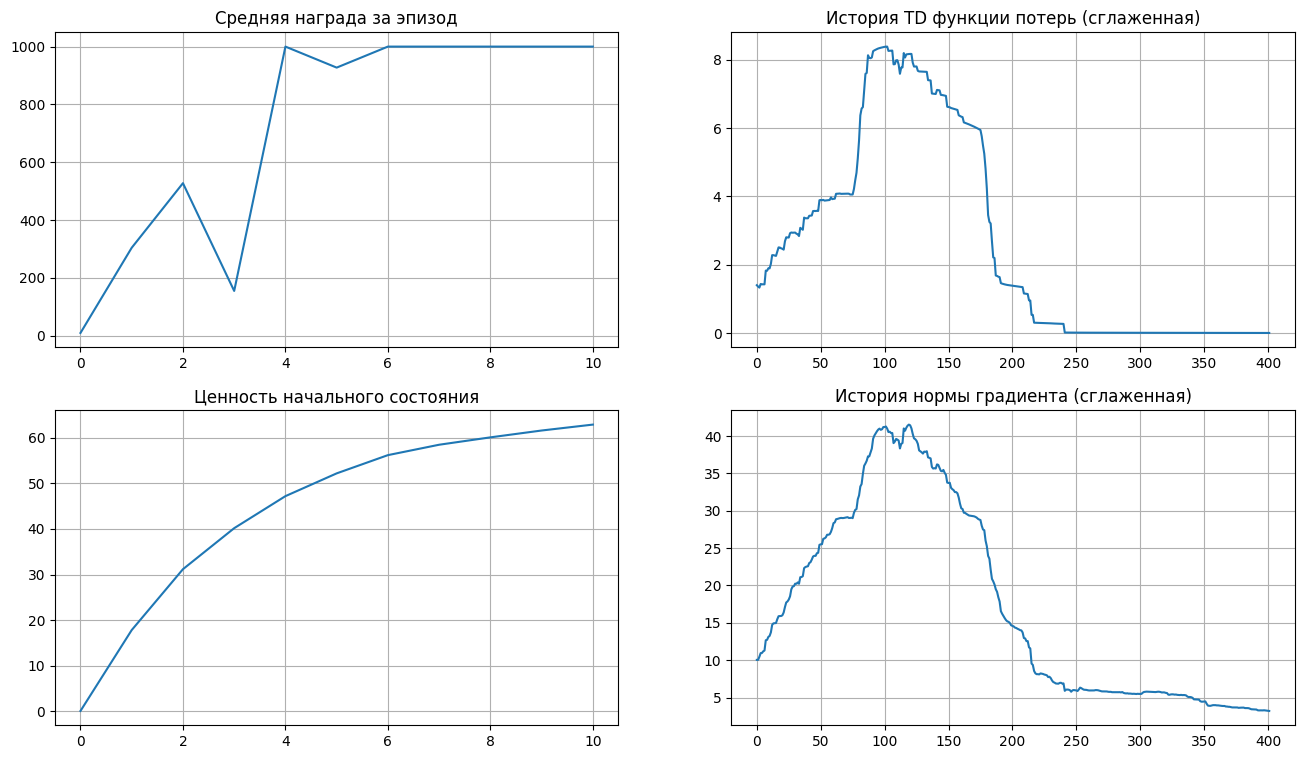

100%|██████████| 10001/10001 [07:13<00:00, 23.06it/s]


In [96]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('Меньше, чем 100 Mb RAM, доступно, заморозка процедуры обучения')
        print('убедитесь, что всё в порядке и пошлите сигнал KeyboardInterrupt для продолжения')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent_2.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # игра
    _, state = play_and_record_multistep(state, agent_2, env, exp_replay, timesteps_per_epoch)

    # обучение
    obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = exp_replay.sample_random(batch_size)

    loss = compute_td_loss_multistep(obs_batch, act_batch, rew_batch, next_obs_batch, done_mask, agent_2, target_network_2, gamma)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent_2.parameters(), max_grad_norm).item()
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history_2.append(loss.data.cpu().item())
        grad_norm_history_2.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Загрузка весов агента в target_network
        target_network_2.load_state_dict(agent_2.state_dict())

    if step % eval_freq == 0:
        # Оценка агента
        mean_rw_history_2.append(evaluate(make_env(), agent_2, n_games=3, greedy=True, t_max=1000))
        initial_state_q_values = agent_2.get_qvalues([make_env().reset()[0]])
        initial_state_v_history_2.append(np.max(initial_state_q_values))

        print("размер буфера = %i, epsilon = %.5f" % (len(exp_replay), agent_2.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Средняя награда за эпизод")
        plt.plot(mean_rw_history_2)
        plt.grid()

        assert not np.isnan(td_loss_history_2[-1])
        plt.subplot(2, 2, 2)
        plt.title("История TD функции потерь (сглаженная)")
        plt.plot(utils.smoothen(td_loss_history_2))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Ценность начального состояния")
        plt.plot(initial_state_v_history_2)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("История нормы градиента (сглаженная)")
        plt.plot(utils.smoothen(grad_norm_history_2))
        plt.grid()

        clear_output(True)
        plt.show()

n_steps=10

In [97]:
mean_rw_history_10 = []
td_loss_history_10 = []
grad_norm_history_10 = []
initial_state_v_history_10 = []

state, _ = env.reset()

agent_10 = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network_10 = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network_10.load_state_dict(agent_10.state_dict())

exp_replay = ReplayBuffer_multistep(10**4, n_steps=10)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Меньше, чем 100 Mb RAM, доступно.
            Убедитесь, что размер буфера не слишком большой.
            Также проверьте, может, другие процессы потребляют сильно много RAM.
            """
             )
        break
    play_and_record_multistep(state, agent_10, env, exp_replay, n_steps=10**2, regime='random')
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

5991


In [98]:
timesteps_per_epoch = 100
batch_size = 64
total_steps = 1 * 10**4
decay_steps = 5 * 10**3

opt = torch.optim.Adam(agent_10.parameters(), lr=1e-3)
opt.zero_grad()

init_epsilon = 0.5
final_epsilon = 0.05

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 10
gamma = 0.99

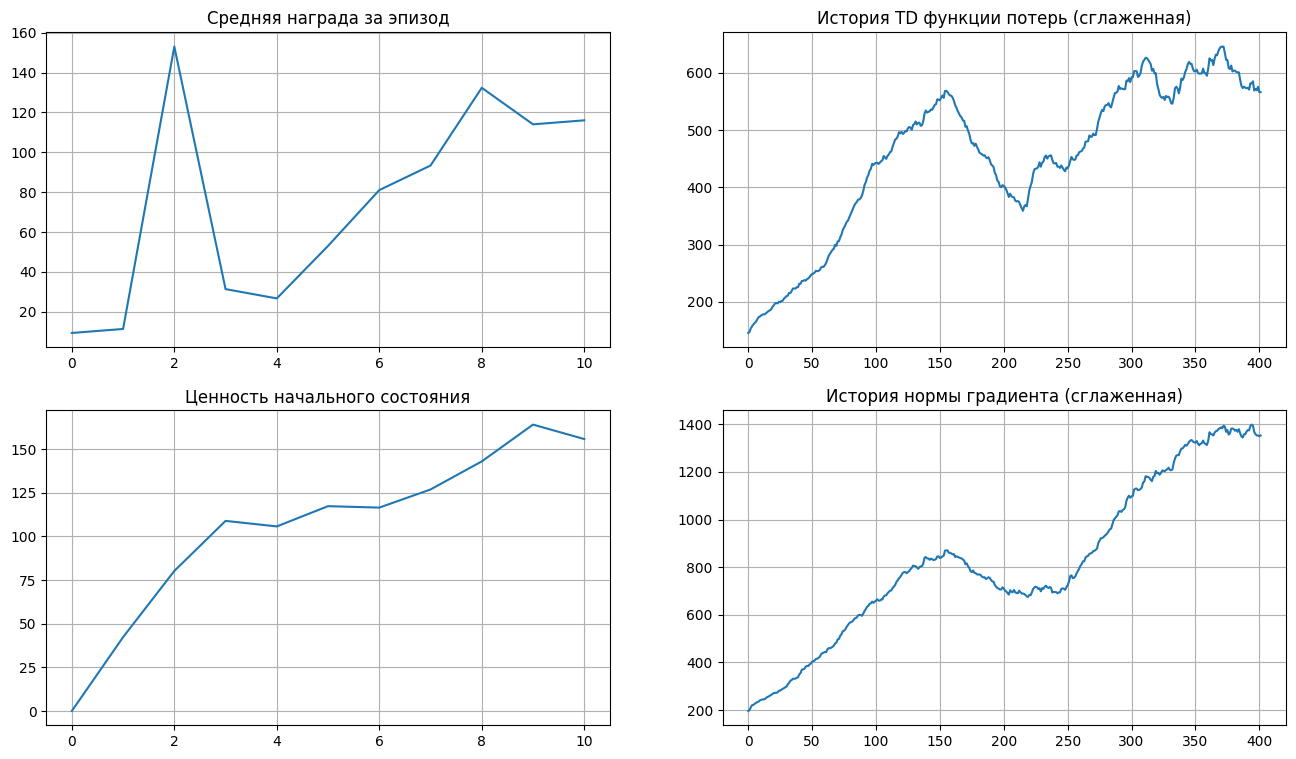

100%|██████████| 10001/10001 [07:21<00:00, 22.66it/s]


In [99]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('Меньше, чем 100 Mb RAM, доступно, заморозка процедуры обучения')
        print('убедитесь, что всё в порядке и пошлите сигнал KeyboardInterrupt для продолжения')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent_10.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # игра
    _, state = play_and_record_multistep(state, agent_10, env, exp_replay, timesteps_per_epoch)

    # обучение
    obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = exp_replay.sample_random(batch_size)

    loss = compute_td_loss_multistep(obs_batch, act_batch, rew_batch, next_obs_batch, done_mask, agent_10, target_network_10, gamma, n_steps=10)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent_10.parameters(), max_grad_norm).item()
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history_10.append(loss.data.cpu().item())
        grad_norm_history_10.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Загрузка весов агента в target_network
        target_network_10.load_state_dict(agent_10.state_dict())

    if step % eval_freq == 0:
        # Оценка агента
        mean_rw_history_10.append(evaluate(make_env(), agent_10, n_games=3, greedy=True, t_max=1000))
        initial_state_q_values = agent_10.get_qvalues([make_env().reset()[0]])
        initial_state_v_history_10.append(np.max(initial_state_q_values))

        print("размер буфера = %i, epsilon = %.5f" % (len(exp_replay), agent_10.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Средняя награда за эпизод")
        plt.plot(mean_rw_history_10)
        plt.grid()

        assert not np.isnan(td_loss_history_10[-1])
        plt.subplot(2, 2, 2)
        plt.title("История TD функции потерь (сглаженная)")
        plt.plot(utils.smoothen(td_loss_history_10))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Ценность начального состояния")
        plt.plot(initial_state_v_history_10)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("История нормы градиента (сглаженная)")
        plt.plot(utils.smoothen(grad_norm_history_10))
        plt.grid()

        clear_output(True)
        plt.show()

RESULT

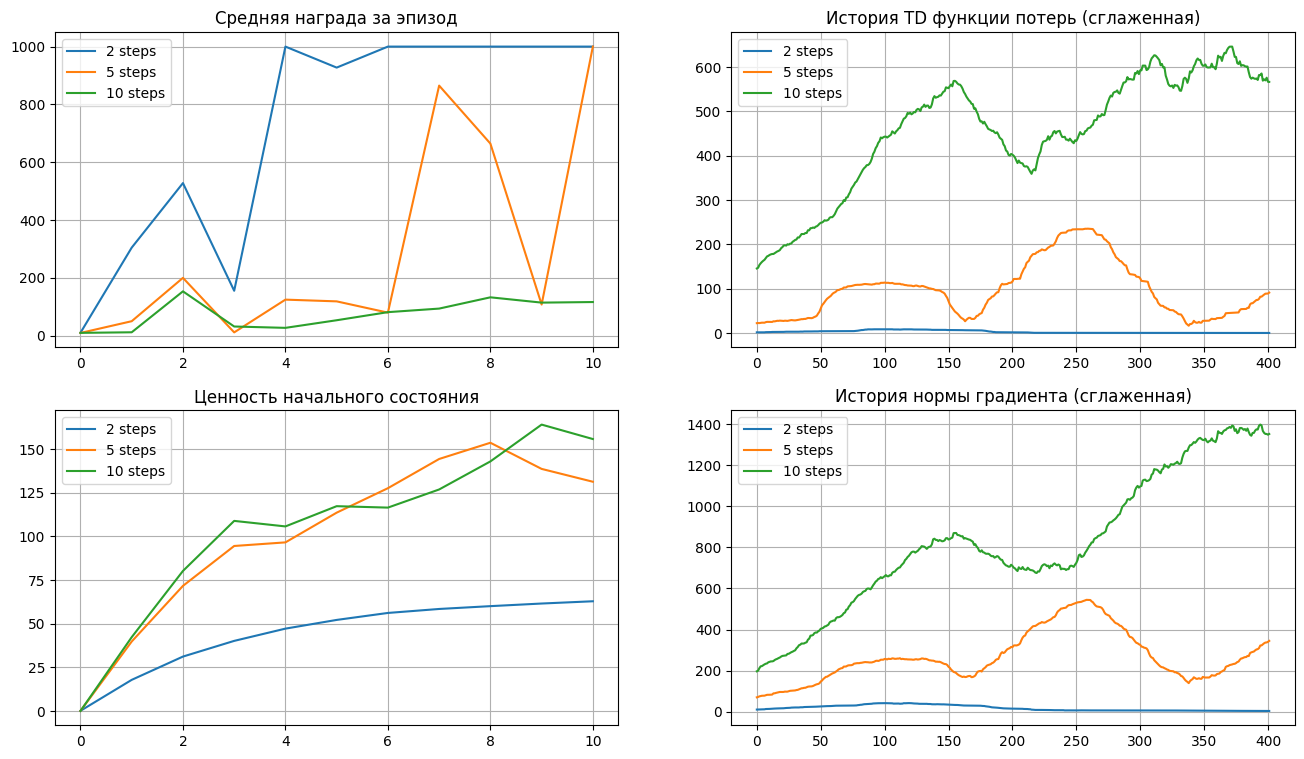

In [100]:
plt.figure(figsize=[16, 9])
plt.subplot(2, 2, 1)
plt.title("Средняя награда за эпизод")
plt.plot(mean_rw_history_2, label="2 steps")
plt.plot(mean_rw_history, label="5 steps")
plt.plot(mean_rw_history_10, label="10 steps")
plt.grid()
plt.legend()

plt.subplot(2, 2, 2)
plt.title("История TD функции потерь (сглаженная)")
plt.plot(utils.smoothen(td_loss_history_2), label="2 steps")
plt.plot(utils.smoothen(td_loss_history), label="5 steps")
plt.plot(utils.smoothen(td_loss_history_10), label="10 steps")
plt.grid()
plt.legend()

plt.subplot(2, 2, 3)
plt.title("Ценность начального состояния")
plt.plot(initial_state_v_history_2, label="2 steps")
plt.plot(initial_state_v_history, label="5 steps")
plt.plot(initial_state_v_history_10, label="10 steps")
plt.grid()
plt.legend()

plt.subplot(2, 2, 4)
plt.title("История нормы градиента (сглаженная)")
plt.plot(utils.smoothen(grad_norm_history_2), label="2 steps")
plt.plot(utils.smoothen(grad_norm_history), label="5 steps")
plt.plot(utils.smoothen(grad_norm_history_10), label="10 steps")
plt.grid()
plt.legend()

clear_output(True)
plt.show()

У нас очень простая среда и multi-step тут совершенно не нужен.

При маленьком значении n_steps сходимся более стабильно, но хуже моделируем на большом горизонте.

При больших значения наоборот. Т.е. это нужно если у нас сложная среда с отложенной наградой.

In [36]:
# запись эпизодов
with RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"),
    video_folder="./videos_Multistep/False",
    episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [evaluate(env_monitor, agent, greedy=False, t_max=1000) for _ in range(5)]

Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-0.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/False/rl-video-episode-4.mp4


In [37]:
video_paths = sorted([s for s in Path('videos_Multistep', 'False').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

In [38]:
# запись эпизодов
with RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"),
    video_folder="./videos_Multistep/True",
    episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [evaluate(env_monitor, agent, greedy=True, t_max=1000) for _ in range(5)]

Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-0.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/QLearning/videos_Multistep/True/rl-video-episode-4.mp4


In [39]:
video_paths = sorted([s for s in Path('videos_Multistep', 'True').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Бонусное задание

<span style="color: green"> __(1 балл)__ </span> Реализуйте семплирование с приоритетами (раздел 4.2.6 в пособии)

<span style="color: green"> __(1 балл)__ </span> Реализуйте шумные сети (раздел 4.2.5 в пособии)

<span style="color: green"> __(2 балла)__ </span> Реализуйте обучение с retrace-оценкой (раздел 4.2.8 в пособии)